In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [2]:
## If your system supports GPU, uncomment the following:

# physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load Dateset


In [3]:
df = pd.read_csv("monthly-milk-production-pounds.csv")
df.head()
# dataset is already sorted by Month column

,Month,Milk Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Month            168 non-null    object
 1   Milk Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


## Data visualization

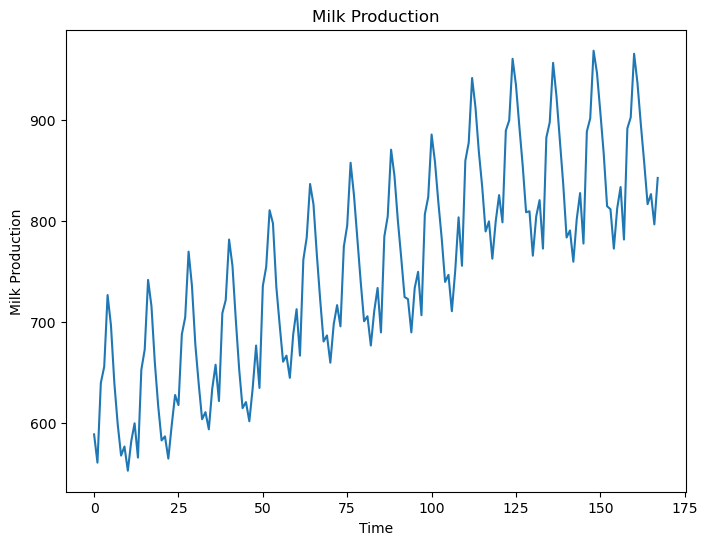

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(df["Milk Production"], label='Actual')
plt.xlabel('Time')
plt.ylabel('Milk Production')
plt.title('Milk Production')
plt.show()

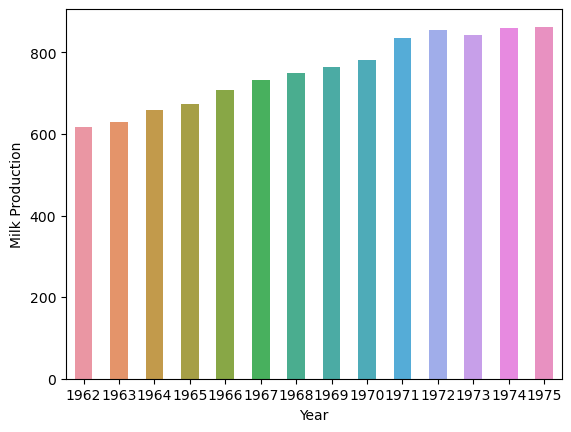

In [6]:
df["Year"] = pd.to_datetime(df["Month"].values).year
a = df.groupby('Year').mean(numeric_only=True)
sns.barplot(x=a.index, y=a["Milk Production"], width=0.5)
df.drop(columns=["Year"], inplace=True)

## Scaling the entire date

In [7]:
data = df["Milk Production"].values

sc = MinMaxScaler()
data = sc.fit_transform(data.reshape(-1, 1))

## Create the dataset based of `sequence_length`

In [8]:
sequence_length = 6

X = []
y = []
for i in range(len(data) - sequence_length):
    X.append(data[i:i + sequence_length])
    y.append(data[i + sequence_length])
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(162, 6, 1) (162, 1)


## Splitting the data to train and test dateset

In [9]:
test_size = int(0.1 * len(X))
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(146, 6, 1) (146, 1)
(16, 6, 1) (16, 1)


## Create a simple CNN model


In [10]:
model = keras.Sequential(name="milk_production_model")

model.add(keras.Input(shape=(sequence_length, 1), name="input_layer"))
model.add(keras.layers.LSTM(60,return_sequences=True))
model.add(keras.layers.LSTM(60))
model.add(keras.layers.Dense(1, name="output_layer"))

model.summary()

Model: "milk_production_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_layer (LSTM)           (None, 60)                14880     
                                                                 
 output_layer (Dense)        (None, 1)                 61        
                                                                 
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


## Compiling the model


In [11]:
model.compile(
    loss="mean_squared_error",
    optimizer="Adam",
)

## Fitting the model


In [12]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
)

Epoch 1/50
5/5 [==============================] - 4s 267ms/step - loss: 0.2522 - val_loss: 0.3327
Epoch 2/50
5/5 [==============================] - 0s 35ms/step - loss: 0.1515 - val_loss: 0.1726
Epoch 3/50
5/5 [==============================] - 0s 49ms/step - loss: 0.0833 - val_loss: 0.0658
Epoch 4/50
5/5 [==============================] - 0s 54ms/step - loss: 0.0427 - val_loss: 0.0291
Epoch 5/50
5/5 [==============================] - 0s 72ms/step - loss: 0.0349 - val_loss: 0.0397
Epoch 6/50
5/5 [==============================] - 0s 61ms/step - loss: 0.0409 - val_loss: 0.0363
Epoch 7/50
5/5 [==============================] - 0s 46ms/step - loss: 0.0365 - val_loss: 0.0283
Epoch 8/50
5/5 [==============================] - 0s 55ms/step - loss: 0.0329 - val_loss: 0.0294
Epoch 9/50
5/5 [==============================] - 0s 74ms/step - loss: 0.0332 - val_loss: 0.0323
Epoch 10/50
5/5 [==============================] - 0s 106ms/step - loss: 0.0335 - val_loss: 0.0311
Epoch 11/50
5/5 [==========

## Evaluationg the model


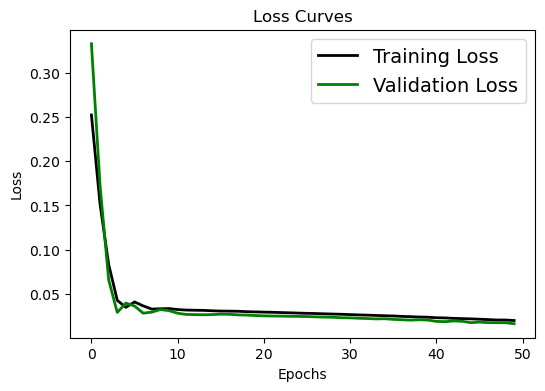

In [15]:
# Loss curve
plt.figure(figsize=[6, 4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)
plt.show()

## Testing the model

1/1 [==============================] - 0s 421ms/step


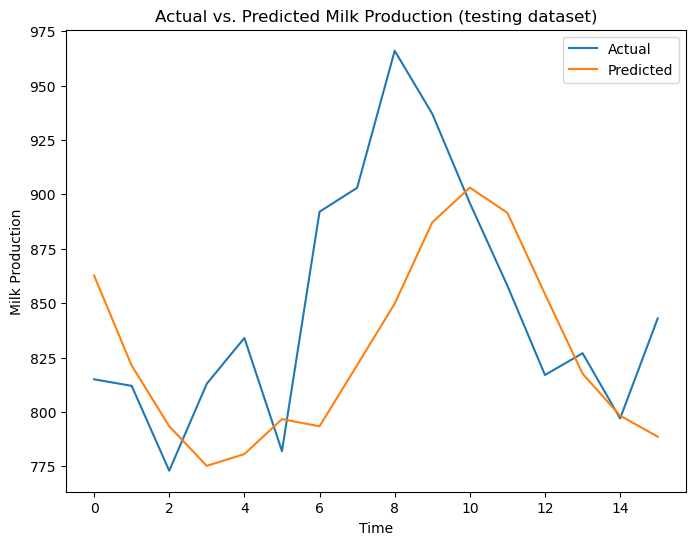

In [16]:
y_pred = model.predict(X_test)

# Plot the actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.plot(sc.inverse_transform(y_test), label='Actual')
plt.plot(sc.inverse_transform(y_pred), label='Predicted')
plt.xlabel('Time')
plt.ylabel('Milk Production')
plt.title('Actual vs. Predicted Milk Production (testing dataset)')
plt.legend()
plt.show()

5/5 [==============================] - 0s 7ms/step


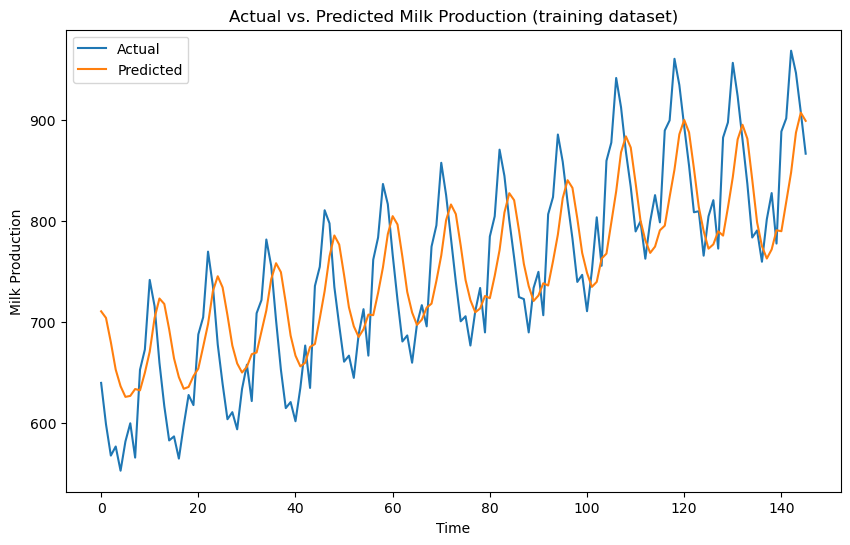

In [17]:
y_pred_train = model.predict(X_train)

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(sc.inverse_transform(y_train), label='Actual')
plt.plot(sc.inverse_transform(y_pred_train), label='Predicted')
plt.xlabel('Time')
plt.ylabel('Milk Production')
plt.title('Actual vs. Predicted Milk Production (training dataset)')
plt.legend()
plt.show()